In [7]:
import pandas as pd
import numpy as np
from scipy import spatial
from gensim.models import Word2Vec

In [8]:
PATH = '/Users/jisungyoon/Dropbox/SME-dropbox/Data/Derived/Descriptive/org/organization_flows.csv'
data = pd.read_csv(PATH)

In [9]:
INPUT_EMBEDDING_FILE = '/Users/jisungyoon/Dropbox/SME-dropbox/Data/Derived/Embeddings/precedence/word2vec_d300_ws1_model.bin'
model = Word2Vec.load(INPUT_EMBEDDING_FILE)
vocab_list = set(list(model.wv.vocab.keys()))
embedding_dict = {k: model.wv[k] for k in vocab_list}
norms = {vocab: np.linalg.norm(embedding_dict[vocab]) for vocab in vocab_list}

In [10]:
INPUT_SIZE_FILE = '/Users/jisungyoon/Dropbox/SME-dropbox/Data/raw/2008-2019_inst_sizes.txt'
size_data = pd.read_csv(INPUT_SIZE_FILE, sep="\t", dtype={"cwts_org_no": str})
size_data = size_data.drop(size_data.index[len(size_data) - 1])
size_data.person_count = size_data.person_count.astype(int)
mean_size_dict = (
    size_data.groupby("cwts_org_no")["person_count"].apply(np.mean).to_dict()
)

In [11]:
reduced_data = data[data.org1.isin(vocab_list)]
reduced_data = reduced_data[reduced_data.org2.isin(vocab_list)]

In [157]:
def l2_power_2_distance(x):
    l2_distance = np.linalg.norm(embedding_dict[str(int(x['org1']))] - embedding_dict[str(int(x['org2']))])
    distance_part = np.power(l2_distance, 2) / 2
    return distance_part

def calculate_cosine_distance(x):
    return spatial.distance.cosine(embedding_dict[str(int(x['org1']))], embedding_dict[str(int(x['org2']))])

def calculate_dot(x):
    return - np.dot(embedding_dict[str(int(x['org1']))], embedding_dict[str(int(x['org2']))])

def get_size_org1(x):
    return mean_size_dict[str(int(x['org1']))]

def get_size_org2(x):
    return mean_size_dict[str(int(x['org2']))]

def get_norm_org1(x):
    return np.exp(np.power(norms[str(int(x['org1']))], 2)/2)

def get_norm_org2(x):
    return np.exp(np.power(norms[str(int(x['org2']))], 2)/2)

def calculate_expected_flow_model1(x):
    return np.log(x['count']/(x['size_org1'] * x['size_org2']))

def calculate_expected_flow_model2(x):
    return np.log(x['count']/(x['norm_org1'] * x['norm_org2']))      

In [17]:
reduced_data = data[data.org1.isin(vocab_list)]
reduced_data = reduced_data[reduced_data.org2.isin(vocab_list)]

In [18]:
reduced_data['cos_distance'] = reduced_data.apply(calculate_cosine_distance, axis=1)
reduced_data['l2_distance'] = reduced_data.apply(l2_power_2_distance, axis=1)

In [158]:
reduced_data['dot_product'] = reduced_data.apply(calculate_dot, axis=1)

In [19]:
reduced_data['size_org1'] = reduced_data.apply(get_size_org1, axis=1)
reduced_data['size_org2'] = reduced_data.apply(get_size_org2, axis=1)

reduced_data['norm_org1'] = reduced_data.apply(get_norm_org1, axis=1)
reduced_data['norm_org2'] = reduced_data.apply(get_norm_org2, axis=1)

In [23]:
reduced_data['expected_flow_model1'] = reduced_data.apply(calculate_expected_flow_model1, axis=1)
reduced_data['expected_flow_model2'] = reduced_data.apply(calculate_expected_flow_model2, axis=1)

In [73]:
reduced_data['size_mul'] = reduced_data['size_org1'] * reduced_data['size_org2']
reduced_data['norm_mul'] = reduced_data['norm_org1'] * reduced_data['norm_org2']

In [159]:
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error
def calculate_r_square_and_plot_figure(data, x_name, y_name, mul_var_name):
    x = getattr(data, x_name)
    y = getattr(data, y_name)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(x_name, y_name, r_value**2)
    
    predicted_first_figure = x * slope + intercept
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
    ax1.hexbin(x,y,bins='log', mincnt=0, cmap='gray_r', gridsize=20)
    ax1.set_xlabel(x_name, fontsize=20)
    ax1.set_ylabel(y_name, fontsize=20)
    
    mul_value = getattr(data, mul_var_name)
    actual_flow = data['count']
    expected_flow = np.exp(intercept) * mul_value * np.exp(slope * x)
    ax2.hexbin(expected_flow, actual_flow, xscale='log', yscale='log', bins='log', gridsize=20, cmap='gray_r', mincnt=0)
    ax2.set_xlabel('predicted_flow', fontsize=20)
    ax2.set_ylabel('actual_flow', fontsize=20)
    
    ax2.axis('equal')
    ax2.plot([0,1],[0,1], transform=ax2.transAxes)
    min_value = min(min(expected_flow), min(actual_flow))
    max_value = max(max(expected_flow), max(actual_flow))
    plt.axis([min_value, ax_value, min_value, max_value])
    
    a = mean_squared_error(np.log10(actual_flow), np.log10(expected_flow))
    b = mean_squared_error(np.log(actual_flow), np.log(expected_flow))
    print(a)
    plt.savefig('{}_{}_{}.pdf'.format(x_name, y_name, mul_var_name))
    
    

l2_distance expected_flow_model1 0.2858473112953063
0.6878156973130447


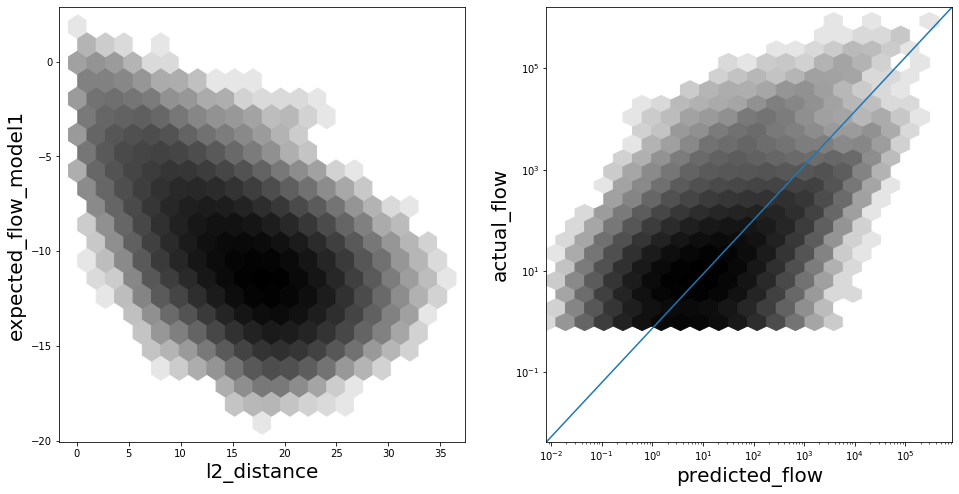

In [160]:
calculate_r_square_and_plot_figure(reduced_data, 'l2_distance', 'expected_flow_model1', 'size_mul')

cos_distance expected_flow_model1 0.48468078471363624
0.49631493517707104


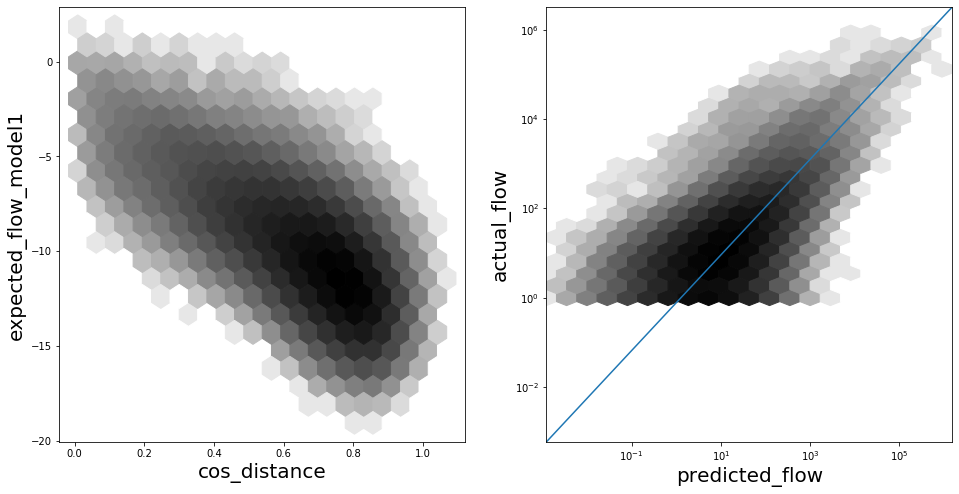

In [161]:
calculate_r_square_and_plot_figure(reduced_data, 'cos_distance', 'expected_flow_model1', 'size_mul')

dot_product expected_flow_model1 0.3355618400314215
0.6399345735841075


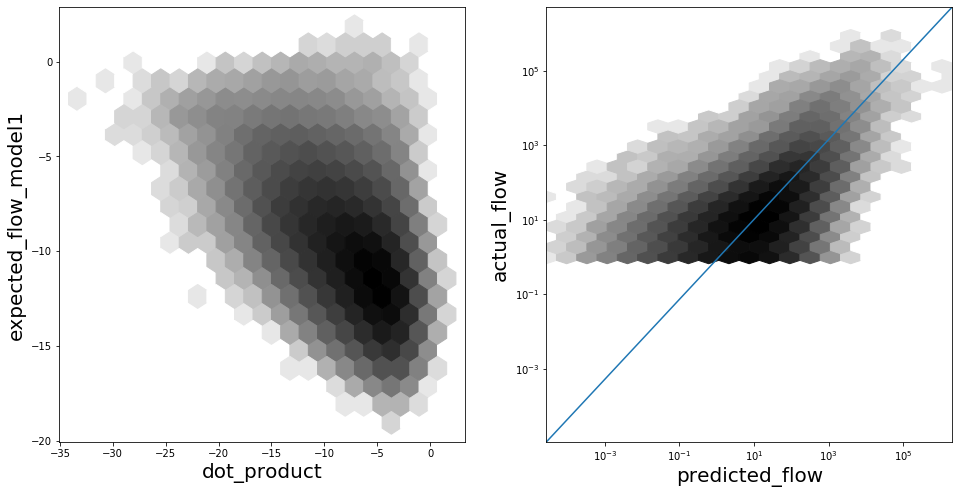

In [162]:
calculate_r_square_and_plot_figure(reduced_data, 'dot_product', 'expected_flow_model1', 'size_mul')

l2_distance expected_flow_model2 0.5962644425556671
1.5837695419683617


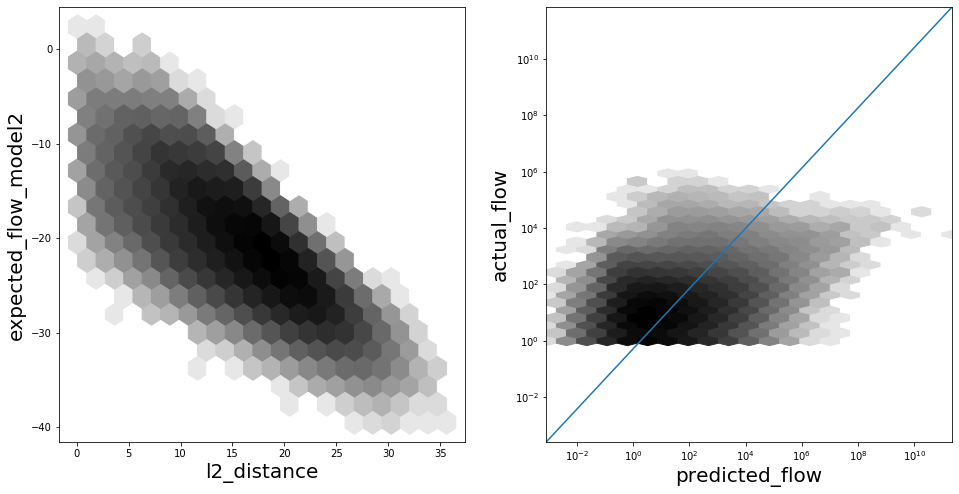

In [163]:
calculate_r_square_and_plot_figure(reduced_data, 'l2_distance', 'expected_flow_model2', 'norm_mul')

cos_distance expected_flow_model2 0.08049737669145582
3.607015091200839


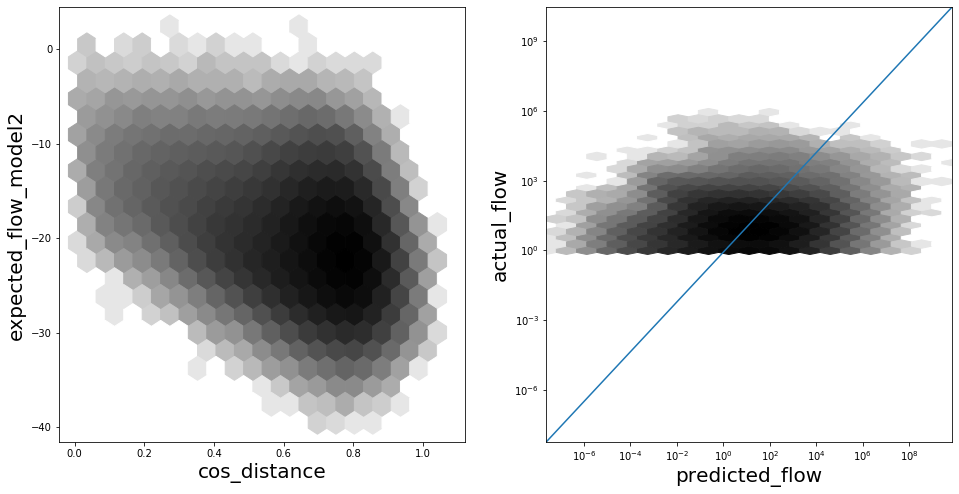

In [164]:
calculate_r_square_and_plot_figure(reduced_data, 'cos_distance', 'expected_flow_model2', 'norm_mul')

dot_product expected_flow_model2 0.02613856759726692
3.820253248191557


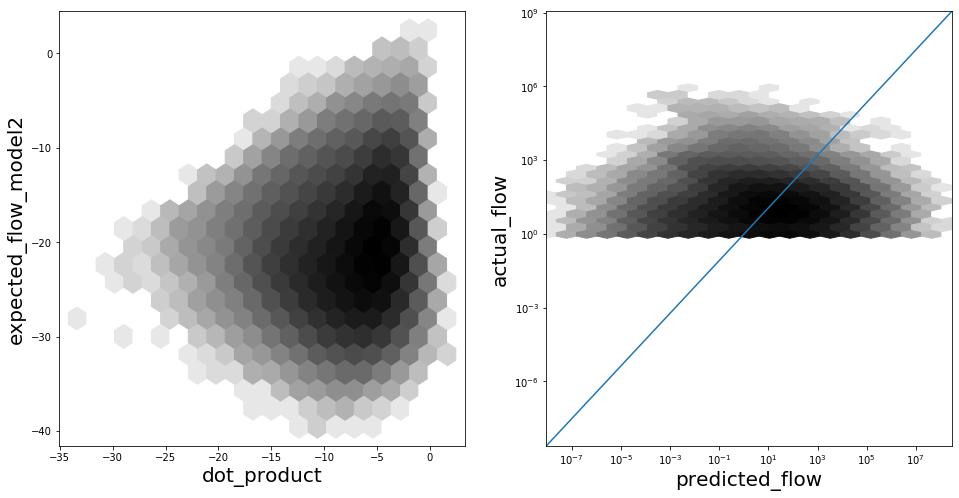

In [165]:
calculate_r_square_and_plot_figure(reduced_data, 'dot_product', 'expected_flow_model2', 'norm_mul')